# Gaussian Process Demo

This notebook briefly describes how to make an variational inference with Henbun.

*Keisuke Fujii, 21st Nov. 2016*

We show 
+ Simple Gaussian Process regression
+ Regression with non-Gaussian likelihood where ananlytical posterior is not available.

# Import libraries

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import Henbun as hb

# Simple regression

## Toy data

In [2]:
X = np.linspace(0,6,40).reshape(-1,1)
Y = np.sin(X) + np.random.randn(40,1)*0.3

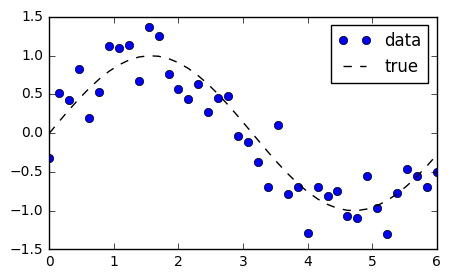

In [3]:
plt.figure(figsize=(5,3))
plt.plot(X, Y, 'o', label='data')
plt.plot(X, np.sin(X), '--k', label='true')
plt.legend(loc='best')

## Construct a Henbun model

In [4]:
# Any model should inherite hb.model.Model
class GPR(hb.model.Model):
    def setUp(self):
        """ 
        Set up parameters and Data for this model.
        Model.setUp is immediately called after Model.__init__()
        """
        # Data should be stored in hb.param.Data class. 
        self.X = hb.param.Data(X)
        self.Y = hb.param.Data(Y)
        
        # Variational parameters. 
        # By default, the shape of the variational covariance is 'diagonal'.
        # In small problems, the fullrank covariance can be inferred.
        self.q = hb.variationals.Gaussian(shape=X.shape, q_shape='fullrank')
        
        # Kernel object for GPR. 
        self.kern = hb.gp.kernels.UnitRBF()
        # Since our kernel does not contain the variance term, 
        # we should multiply positive parameter by hand.
        # To constrain k_var to stay in positive space, set transform option.
        self.k_var = hb.param.Variable(shape=[1], transform=hb.transforms.positive)
        
        # likelihood variance, which is also positive parameter.
        self.var = hb.param.Variable(shape=[1], transform=hb.transforms.positive)
        
    @hb.model.AutoOptimize()
    def ELBO_gaussian(self):
        """
        Any method decorated by @AutoOptimize can be optimized.
        In the decorated method, [hb.param.Variable, hb.variationals.Variational, 
        hb.param.Data] objects are treated as tf.Tensor.
        Therefore, tensorflow's method can be directoly used.
        
        Here, we calculate ELBO that should be maximized.
        """
        y_fit = tf.matmul(self.kern.Cholesky(self.X), self.q) * tf.sqrt(self.k_var)
        
        # Kulback-Leibler divergence can be accessed by self.KL() method.
        return tf.reduce_sum(hb.densities.gaussian(self.Y, y_fit, self.var))\
                - self.KL()
        
    @hb.model.AutoOptimize()
    def ELBO_student(self):
        """
        It is often convenient to prepare several variants of target method.
        In this method, we assume Student's t distribution as likelihood.
        """
        y_fit = tf.matmul(self.kern.Cholesky(self.X), self.q) * tf.sqrt(self.k_var)
        # Kulback-Leibler divergence can be accessed by self.KL() method.
        return tf.reduce_sum(hb.densities.student_t(self.Y, y_fit, self.var, 3.0))\
                - self.KL()

In [5]:
model_gpr = GPR()

## Train the Henbun model

In [6]:
# First, we need a compilation of the model
model_gpr.ELBO_gaussian().compile()

compiling...


In [7]:
# To evaluate this method with current parameters, run() method can be used.
model_gpr.ELBO_gaussian().run()

-526.71045

In [8]:
# To optimize this method, optimize() method can be used.
model_gpr.ELBO_gaussian().optimize(maxiter=10000)

In [9]:
# See the resultant ELBO value
model_gpr.ELBO_gaussian().run()

-15.30363

## Plot the results

In [10]:
# There are some options to obtain the result.
# Most primitive way is to make an op and then run by model.run() method with appropriate feed_dict.
with model_gpr.tf_mode():
    op = tf.matmul(model_gpr.kern.Cholesky(model_gpr.X), model_gpr.q) * tf.sqrt(model_gpr.k_var)

# In each run, the different samples are taken from the variational parameters
f_samples = [model_gpr.run(op) for _ in range(30)]

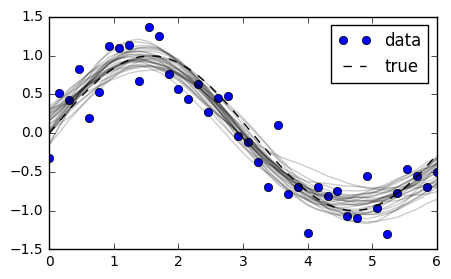

In [11]:
plt.figure(figsize=(5,3))
plt.plot(X, Y, 'o', label='data')
for s in f_samples: plt.plot(X, s,'k', alpha=0.2)
plt.plot(X, np.sin(X), '--k', label='true')
plt.legend(loc='best')

## Obtain the optimized parameters

In [12]:
# To get the current parameters, .value property can be used.

In [13]:
print('kernel lengthscale', model_gpr.kern.lengthscales.value)
print('kernel variance',    model_gpr.k_var.value)
print('likelihood variance',model_gpr.var.value)

kernel lengthscale [ 1.4416014]
kernel variance [ 0.55555749]
likelihood variance [ 0.08107395]


# Non-Gaussian likelihood model
In this example, we demonstrate the use of non-gaussian likelihood in Gaussian Process Regression.

In [14]:
# We added some outliers to the above Toy dat
Y[np.random.randint(0,X.shape[0],5),0] = 2*np.random.randn(5) # Add non-Gaussian noise

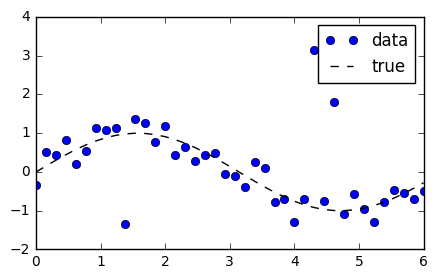

In [15]:
plt.figure(figsize=(5,3))
plt.plot(X, Y, 'o', label='data')
plt.plot(X, np.sin(X), '--k', label='true')
plt.legend(loc='best')

## Replace the data of the existing model

In [16]:
# Just assign new values
model_gpr.X = X
model_gpr.Y = Y

## Training with Gaussian likelihood

In [17]:
model_gpr.ELBO_gaussian().compile()
model_gpr.ELBO_gaussian().optimize(maxiter=10000)

compiling...


In [18]:
f_samples = [model_gpr.run(op) for _ in range(30)]

## Training with Student's likelihood

In [19]:
# To optimize this method, optimize() method can be used.
model_gpr.ELBO_student().compile()
model_gpr.ELBO_student().optimize(maxiter=10000)

compiling...


In [20]:
f_samples_student = [model_gpr.run(op) for _ in range(30)]

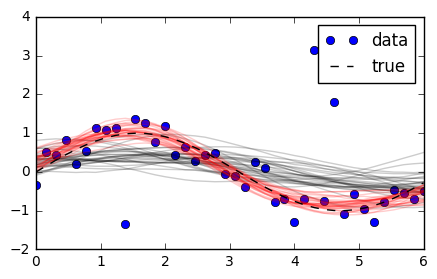

In [21]:
plt.figure(figsize=(5,3))
plt.plot(X, Y, 'o', label='data')
for s in f_samples: plt.plot(X, s,'k', alpha=0.2)
for s in f_samples_student: plt.plot(X, s,'r', alpha=0.2)
plt.plot(X, np.sin(X), '--k', label='true')
plt.legend(loc='best')

# Note

The above is an simple example of Henbun usage.

However, Henbun is not very efficient for such a simple problem.  
Another single-purpose library such as [GPflow](https://github.com/GPflow/GPflow/blob/master/GPflow/likelihoods.py) is much faster.